# NMF (Non-Negative Matrix Factorization; 非負値行列因子分解)

## NMFとは


NMFは，非負値($>=0$)の元行列 $\mathbf{V}$ を他の２つの非負値な行列 $\mathbf{W}, \mathbf{H}$の積で近似するアルゴリズムです．例えばユーザーごとの購買履歴を保存した行列$\mathbf{V}$が与えられた時に，これをユーザー数$D$✖️所与の埋め込み次元$K$（$K$は元の特徴数よりもかなり小さい値）の行列$\mathbf{W}$と$K$✖️特徴数$F$の行列$\mathbf{H}$に分解するようなタスクです．これらの二つの行列に何かしらの演算（ここでは積を取ります）をして，元の行列に近い行列を再構築できるようにすることで，より小さい二つの行列で元の行列を圧縮することができていると言えます．このようなタスクを行列分解と呼びます．

学習にはさまざまな方法があります．

1. 乗法更新式
    - 損失関数として定義するユークリッド距離やIダイバージェンスを，パラメタ更新の度に小さくするような更新式を利用します．これは数学的に損失関数が収束することが証明されています．
2. 勾配法
    - Neural Netの訓練でも利用されるアルゴリズムです．そのまま使うと$W$や$H$には0未満の値が含まれてしまうので，0未満になる場合は0で置き換えるような処理を追加して利用します．収束するとは限りませんが，実装は簡単です．

## scikit-learnを使った実験

NMFはscikit-learnに実装されているので，これを利用してみましょう．

In [20]:
import numpy as np
import pandas as pd 
import plotly.express as px 
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF 
from sklearn.exceptions import NotFittedError
from tqdm.auto import trange
import plotly.express as px 
import matplotlib.pyplot as plt

今回は20news groupsというテキストデータを利用します．BoWに変換しているので，行列の要素は全て0以上になります．

In [2]:
news_train = fetch_20newsgroups(subset="train")
news_test = fetch_20newsgroups(subset="test")
vectorizer = CountVectorizer(lowercase=True, max_features=1000, stop_words="english", min_df=2, max_df=0.5)
X_train = vectorizer.fit_transform(news_train.data)
X_test = vectorizer.transform(news_test.data)

In [3]:
id2word = {id:key for id,key in enumerate(vectorizer.get_feature_names())}
word2id = {key:id for id,key in id2word.items()}

/Users/mriki/.pyenv/versions/miniforge3-4.10.3-10/envs/datasci/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
nmf = NMF(n_components=20)
nmf.fit(X_train)
W_doc_k = nmf.transform(X_test)
print(W_doc_k.shape)
H_k_vocab = nmf.components_
print(H_k_vocab.shape)

(7532, 20)
(20, 1000)


In [33]:
nmf.reconstruction_err_ #/ X_train.shape[0]

1488.503298672555

## NumPyを使って実装する

ユークリッド距離を損失関数にして，乗法更新式による訓練を行います． 

できるだけ行列計算を行う行にはshapeをコメントしてあります．プログラムを読む時に参考にしてください．

In [8]:
def update_Vt_by_euclid(X, U, Vt):
    _X = U @ Vt # (D,F)=(D,K)@(K,F)
    _bias = (U.T @ X) / (U.T @ _X) # (D,K).T@(D,F) / (D,K).T@(D,F)
    _bias[np.isnan(_bias)] = 0.0
    Vt *= _bias # (K,F)=(K,F)*(K,F)
    return Vt 

def update_U_by_euclid(X,U,Vt):        
    _X = U @ Vt # (D,F)=(D,K)@(K,F)
    _bias = (X @ Vt.T) / (_X @ Vt.T) # (D,F)@(K,F).T / (D,F)@(K,F).T
    _bias[np.isnan(_bias)] = 0
    U *= _bias # (D,K)=(D,K)(D,K)
    return U

def cost_fn_by_euclid(X,_X):
    return np.linalg.norm(X - _X, axis=1).mean()

class MyNMF():
    def __init__(self, n_components:int=2, max_iter:int=100, rng:bool=None, divergence="euclid"):
        self.n_components = n_components
        self.max_iter = max_iter
        self.rng_ = rng if rng is not None else np.random.default_rng(2**1000) 
        self.divergence = divergence
        self.is_fitted = False 
        self.cost_ = []
        if self.divergence == "euclid":
            self.update_Vt = update_Vt_by_euclid
            self.update_U = update_U_by_euclid
            self.cost_fn = cost_fn_by_euclid
        else:
            NotImplementedError('divergenceは["eculid",]から選択')

    def fit_transform(self, X:np.ndarray,y=None):
        X = X.astype(np.float64)
        self._n_features = X.shape[1]
        
        # Initialize two small matrices from a uniform distribution
        _U = self.rng_.uniform(0,1, 
                              size=[X.shape[0],self.n_components],
                              ).astype(X.dtype) # (D,K)
        _Vt = self.rng_.uniform(0,1,
                                size=[self.n_components, self._n_features],
                                ).astype(X.dtype) # (K,F)
        
        # update parameters
        for i in trange(self.max_iter):
            _Vt = self.update_Vt(X,_U,_Vt)
            _U = self.update_U(X,_U,_Vt)
            _X = _U@_Vt
            self.cost_.append(self.cost_fn(X, _X))
        
        # output
        self.components_ = _Vt # Store _Vt in instance variable to be accessed from outside
        self.is_fitted = True # Raise the flag
        return _U
    
    def fit(self,X,y=None):
        self.fit_transform(X)
        return self
    
    def transform(self, X):
        if not self.is_fitted:
            raise NotFittedError(f"{self.__class__.__name__}.transformはfit後にのみ利用できる")
        if self.components_.shape[1] != X.shape[1]:
            raise ValueError("Xと訓練データの特徴数が異なっている")
        X = X.astype(np.float64)
        
        # Initialize U from a uniform distribution
        U = self.rng_.uniform(0,1, 
                              size=[X.shape[0],self.n_components],
                              ).astype(X.dtype) # (K,F)
        
        for i in trange(self.max_iter):
            U = self.update_U(X,U,self.components_)
        return U

### 訓練の実行

In [34]:
mynmf = MyNMF(20,max_iter=100)
U = mynmf.fit_transform(X_train)

100%|██████████| 100/100 [00:12<00:00,  7.94it/s]


最後の更新時の損失関数の値: 10.900271385543064


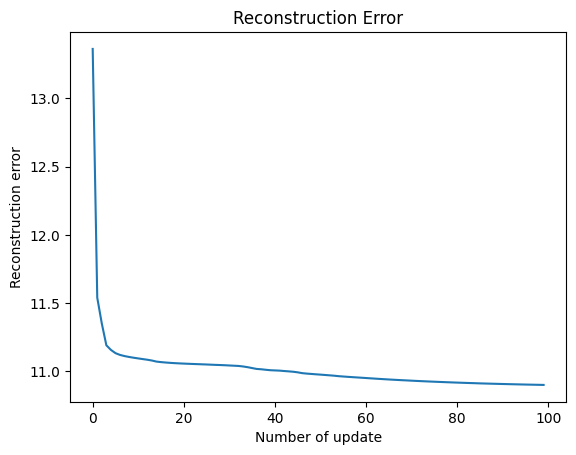

In [38]:
fig = plt.figure()
ax = fig.add_subplot()
_cost = np.array(mynmf.cost_) #/X_train.shape[0]
ax.plot(_cost)
ax.set_xlabel("Number of update")
ax.set_ylabel("Reconstruction error")
ax.set_title("Reconstruction Error")
print("最後の更新時の損失関数の値:",_cost[-1])